# GRU Time Series Forecasting


## Imports


In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from glob import glob
import scipy.io
import IPython
import time
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import math
from scipy.io import wavfile

### Function Definitions


In [2]:
def create_train_test_set(data, window_size):
    raw_data = data.to_numpy()  # convert to numpy array
    data = []

    # create all possible sequences of length window_size
    for current_index in range(len(raw_data) - window_size):
        data.append(raw_data[current_index : current_index + window_size])

    data = np.array(data)
    test_set_size = int(np.round(0.2 * data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)

    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]

    x_test = data[train_set_size, :-1]
    y_test = data[train_set_size, -1, :]

    return [x_train, y_train, x_test, y_test]

In [3]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.output_layer(out[:, -1, :])
        return out

## Multi-layer Gated Recurrent Unit Recurrent Neural Network (GRU)


### Importing Data & Normalizing the Neural Data


In [53]:
data_dir = "../../data/"
data_file_l = glob(data_dir + "*.wav")
rate, data = wavfile.read(data_file_l[0])
df = pd.DataFrame(data, columns=["Amplitude"])
df.index.name = "Sample"

In [54]:
# The values are normalized between -1 and 1
scaler = MinMaxScaler(feature_range=(-1, 1))
df["Amplitude"] = scaler.fit_transform(df["Amplitude"].values.reshape(-1, 1))

### Splitting the Data into Training & Testing Sets


In [55]:
x_train, y_train, x_test, y_test = create_train_test_set(df, window_size=20)

In [8]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

#### Defining the Neural Network


In [9]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

model = GRU(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    num_layers=num_layers,
)

criterion = nn.MSELoss(reduction="mean")
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

#### Training the Neural Network


In [10]:
hist = np.zeros(num_epochs)

In [11]:
%%time
gru = []

for t in range(num_epochs):
    y_train_pred = model(x_train)
    
    loss = criterion(y_train_pred, y_train)
    print('Epoch ', t, 'MSE: ', loss.item())
    hist[t] = loss.item()
    
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

Epoch  0 MSE:  0.08051182329654694
Epoch  1 MSE:  0.07728022336959839
Epoch  2 MSE:  0.06322275847196579
Epoch  3 MSE:  0.04830668494105339
Epoch  4 MSE:  0.04263068735599518
Epoch  5 MSE:  0.04042736068367958
Epoch  6 MSE:  0.030609171837568283
Epoch  7 MSE:  0.017245925962924957
Epoch  8 MSE:  0.01267309207469225
Epoch  9 MSE:  0.015718255192041397
Epoch  10 MSE:  0.02012903243303299
Epoch  11 MSE:  0.014976720325648785
Epoch  12 MSE:  0.008343742229044437
Epoch  13 MSE:  0.008398642763495445
Epoch  14 MSE:  0.010536055080592632
Epoch  15 MSE:  0.011786387301981449
Epoch  16 MSE:  0.011929882690310478
Epoch  17 MSE:  0.011466299183666706
Epoch  18 MSE:  0.010615473613142967
Epoch  19 MSE:  0.009261364117264748
Epoch  20 MSE:  0.007580666337162256
Epoch  21 MSE:  0.006444071885198355
Epoch  22 MSE:  0.006639488041400909
Epoch  23 MSE:  0.007644901517778635
Epoch  24 MSE:  0.008144857361912727
Epoch  25 MSE:  0.007854542694985867
Epoch  26 MSE:  0.007282943930476904
Epoch  27 MSE:  0.0

#### Reformatting the Data


In [12]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train.detach().numpy()))

In [19]:
result_df = pd.concat([original, predict], axis=1)

In [20]:
result_df.columns = ["Truth", "Pred"]

In [23]:
result_df.index.name = "Sample"

In [26]:
result_df["Residuals"] = result_df["Truth"] - result_df["Pred"]

In [38]:
result_df.head()

,Truth,Pred,Residuals
Sample,,,
0,736.0,1226.996338,-490.996338
1,672.0,814.898682,-142.898682
2,1376.0,746.503967,629.496033
3,1120.0,1299.970459,-179.970459
4,1376.0,1093.922485,282.077515


In [45]:
result_df.loc[(result_df["Residuals"] > -10) & (result_df["Residuals"] < 10)]

,Truth,Pred,Residuals
Sample,,,
49,415.000000,420.628479,-5.628479
78,1697.000000,1696.457520,0.542480
97,95.000023,94.155479,0.844543
194,159.000015,160.301590,-1.301575
210,-1762.000122,-1756.588379,-5.411743
...,...,...,...
78656,-545.000061,-542.686218,-2.313843
78679,223.000015,224.538132,-1.538116
78750,1569.000000,1565.498657,3.501343


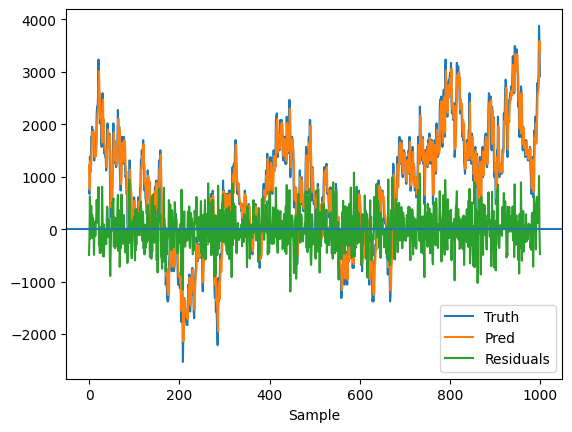

In [37]:
result_df.head(1000).plot()
plt.axhline(y=0)
plt.show()